Source:

huggingface: https://huggingface.co/HooshvareLab/bert-fa-base-uncased-clf-persiannews

Tutorial:https://towardsdatascience.com/fine-tuning-hugging-face-model-with-custom-dataset-82b8092f5333

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/sharif/FineTuning/ipython(guide)')

In [4]:
!pip install transformers

     |████████████████████████████████| 1.8MB 16.3MB/s 
     |████████████████████████████████| 2.9MB 56.0MB/s 
     |████████████████████████████████| 890kB 50.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=c178c87b67ba3d47e7652e99e35761f9ee34c58265836012dee94418d3742316
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [5]:
!pip3 install sentencepiece

     |████████████████████████████████| 1.2MB 12.1MB/s 


In [6]:
!git clone https://huggingface.co/HooshvareLab/bert-fa-base-uncased-clf-persiannews
GIT_LFS_SKIP_SMUDGE=1

fatal: destination path 'bert-fa-base-uncased-clf-persiannews' already exists and is not an empty directory.


In [7]:
!pip install -q clean-text[gpl]

     |████████████████████████████████| 71kB 7.8MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 245kB 28.8MB/s 


In [8]:
!pip install -q hazm

     |████████████████████████████████| 317kB 13.0MB/s 
     |████████████████████████████████| 235kB 41.7MB/s 
     |████████████████████████████████| 1.4MB 53.7MB/s 


In [9]:
import torch
import numpy
import pandas
import re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification,AutoConfig,TFAutoModel,AutoModel
from transformers import BertConfig, BertTokenizer
from transformers import TFBertModel, TFBertForSequenceClassification
from transformers import glue_convert_examples_to_features, InputExample
from sklearn.metrics import classification_report

import hazm
from cleantext import clean


In [ ]:
# specify GPU
device = torch.device("cuda")

## Data

In [43]:
data = pandas.read_csv('/content/drive/MyDrive/sharif/Spider/Data/unpreprocessed_dataset.csv')

In [12]:
# counter
count_data = data.copy()
count_data = count_data.dropna().reset_index(drop=True)
count = {}
tags_list = pandas.read_excel('../Tags.xlsx',header = None)
tags_list.columns = ['tag']
for _,tag in tags_list.iterrows():
  if tag['tag']!='ویرگول' and tag['tag']!=None and tag['tag']!='':
    count[re.sub(' ','',tag['tag'].lower())] = 0

for indx,d in count_data.iterrows():
  tags = re.sub('\'|\[|\]','',d['tag']).split(',')
  
  for tag in tags:
    if tag.strip().lower() in tags_list.values:
      count[tag.strip().lower().replace(' ','')]+=1 
# count

In [34]:
import operator
sorted_counter = sorted(count.items(), key=operator.itemgetter(1))
len(sorted_counter)

mid = len(sorted_counter)//2
sorted_counter[mid][0] , sorted_counter[mid+1][0]

('api', 'oop')

In [44]:
for _,d in data.iterrows():
  tags = re.sub('\"|\[|\]|\'|=',' ',d['tag']).split()

  new_tags = []
  if 'api' in tags:
    new_tags.append('api')
  if 'oop' in tags:
    new_tags.append('oop')

  if len(new_tags) > 0:
    d['tag'] = str(new_tags)
  else:
    d['tag'] = None

data.head()

,body,tag
0,اگر جزو آن دسته دولوپرهایی هستید که پس از چندی...,None
1,دولوپرها همواره به ابزارهای مختلفی نیاز دارند ...,None
2,چنانچه افرادی را می‌شناسید که جزو توسعه‌دهندگا...,None
3,Microsoft Research Open Data یک ریپازیتوری مبت...,None
4,امروزه کامپیوترها بخش مهم و بزرگی از زندگی ما ...,None


In [45]:
tags

['جاوا', 'اسکریپت']

In [46]:
data = data.dropna().reset_index(drop=True)
print(data.shape)
data.head()

(1044, 2)


,body,tag
0,Emojicode یک زبان برنامه‌نویسی اپن‌سورس است که...,['oop']
1,در علوم کامپیوتر و ریاضیات، Enumeration یا به ...,['oop']
2,API List وب‌سایتی است دربرگیرندهٔ لیستی از مجم...,['api']
3,استک اورفلو از سال ۲۰۰۸ تاکنون توانسته جایش را...,['oop']
4,در پروسهٔ طراحی API، دولوپرها نیاز دارند تا با...,['api']


In [ ]:
X = data["body"].values.tolist()
y=data["tag"].values.tolist()
labels = []
tag=[]
for item in y:
  labels += [i for i in re.sub('\"|\[|\]|\'| |=','',item.lower()).split(",") if i!='' and i!=' ']
  tag.append([i for i in re.sub('\"|\[|\]|\'| |=','',item.lower()).split(",") if i!='' and i!=' '])
labels = list(set(labels))
mlb = MultiLabelBinarizer()
Y=mlb.fit_transform(tag)

In [ ]:
# for i in range(10):
#   print(X[i])
#   print(Y[i])

In [ ]:
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext


def cleaning(text):
    text = text.strip()
    
    # regular cleaning
    text = clean(text,
        fix_unicode=True,
        to_ascii=False,
        lower=True,
        no_line_breaks=True,
        no_urls=True,
        no_emails=True,
        no_phone_numbers=True,
        no_numbers=False,
        no_digits=False,
        no_currency_symbols=True,
        no_punct=False,
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="0",
        replace_with_currency_symbol="",
    )

    # cleaning htmls
    text = cleanhtml(text)
    
    # normalizing
    normalizer = hazm.Normalizer()
    text = normalizer.normalize(text)
    
    # removing wierd patterns
    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        # u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)
    
    text = wierd_pattern.sub(r'', text)
    
    # removing extra spaces, hashtags
    text = re.sub("#", "", text)
    text = re.sub("\s+", " ", text)
    
    return text

In [ ]:
# cleaning taxt
clean_x=[]
for t in X:
  clean_x.append(cleaning(t))


In [ ]:
y__=[]
x__=[]
for i in range(len(clean_x)):
  if 'اینترنت' in tag[i]:
    x__.append(clean_x[i])
    y__.append(0)
  elif 'c' in tag[i]:
    x__.append(clean_x[i])
    y__.append(1)

In [ ]:
for i in range(10):
  print(clean_x[i])

اگر جزو آن دسته دولوپرهایی هستید که پس از چندین و چند سال کدنویسی و کسب تجربه کماکان از عملکرد خود راضی نیستید، توصیه می‌‌کنیم به ارزیابی دقیق‌تر کار خود بپردازید. به عبارت دیگر، ببینید که آیا حرفه‌‌ای عمل می‌‌کنید؟ آیا از نسبت میان میزان proficiency و competency خود اطلاع دارید؟ آیا می‌‌دانید چه راه‌کارهایی را برای افزایش بهره‌‌وری خود می‌بایست در پیش بگیرید؟ واقعیت امر آن است که در اغلب موارد، دو مفهوم proficiency و competency مشابه یکدیگر در نظر گرفته می‌شوند؛ اما در حقیقت این‌طور نیست! چنانچه این دو واژه واقعا هم‌معنا بودند، هر کسی که در هر کاری سررشته داشت می‌بایست در کار خود بهترین می‌بود؛ به‌ علاوه اینکه شکی نیست که در قرن بیست و یکم، هر روز بیش از روز قبل نیاز به کسب تخصص احساس می‌شود. با‌توجه به میزان و شتاب گسترش اطلاعات از یک سو و همچنین رقابت شدید متخصصان برای ربودن گوی سبقت از رقبای خود از سوی دیگر، قطعا کسب proficiency برای فعالان حوزهٔ کسب‌وکار یک ضرورت است. به‌ طور کلی، آنچه در ادامه قصد داریم مورد بررسی قرار دهیم این است که به چه شکل می‌توان با تلفیق proficiency و comp

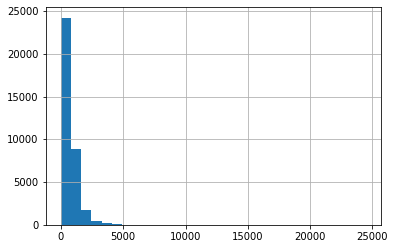

In [ ]:
seq_len = [len(i.split()) for i in X]
pandas.Series(seq_len).hist(bins = 30)

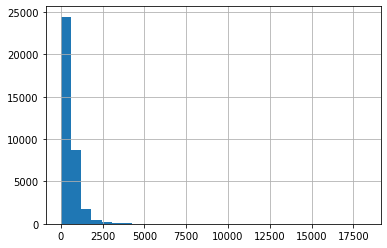

In [ ]:
seq_len = [len([j for j in i.split() if len(j)>2]) for i in X]
pandas.Series(seq_len).hist(bins = 30)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x__,y__ , test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)
print('train: ', len(X_train) , '\ntest: ', len(X_test) , '\nval: ', len(X_val) ,"\ny_tain:",len(y_train) )

train:  2347 
test:  783 
val:  783 
y_tain: 2347


In [ ]:
##we would load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased-clf-persiannews")

In [ ]:
#example
text = "ما در هوشواره معتقدیم با انتقال صحیح دانش و آگاهی، همه افراد میتوانند از ابزارهای هوشمند استفاده کنند. شعار ما هوش مصنوعی برای همه است."
tokenized=tokenizer.tokenize(X_train[0])
input_ids = tokenizer.convert_tokens_to_ids(tokenized)
print(tokenized)
print(input_ids)


['تعمیر', 'یک', 'دستگاه', 'در', 'مقایسه', 'با', 'تعویض', 'کلی', 'ان', 'میتواند', 'یک', 'گزینه', 'بسیار', 'ارزانتر', 'محسوب', 'شود', '.', 'اما', 'کدام', 'دستگاههای', 'سال', '۲۰۱۹', 'سادهترین', 'تعمیر', '##پذیری', 'و', 'کدامیک', 'تعمیر', 'سختتری', 'داشتند', '؟', 'شرکت', 'ifixit', 'تا', 'رتبه', 'بندی', 'تعمیر', '##پذیری', 'گوشیها', 'از', 'بهترین', 'تا', 'بدترین', 'انها', 'در', 'سال', '۲۰۱۹', 'را', 'منتشر', 'کرد', '.', 'در', 'زیر', 'نتایج', 'این', 'بررسی', 'برای', 'شما', 'گرداوری', 'شده', 'است', '.', 'بهترین', 'دستگاههای', 'قابل', 'تعمیر', '۲۰۱۹', ':', 'در', 'همه', 'موارد', 'بالا', '،', 'سهولت', 'دسترسی', 'و', 'سادگی', 'حذف', 'و', 'جایگزینی', 'قطعات', 'مورد', 'تحسین', 'قرار', 'گرفته', 'است', '.', 'در', 'برخی', 'موارد', '،', 'وجود', 'شاخصههای', 'خاص', 'این', 'دستگاهها', 'نیز', 'موجب', 'افزایش', 'رای', 'شده', 'است', '.', 'دستگاههای', 'با', 'کمترین', 'قابلیت', 'تعمیر', 'در', 'سال', '۲۰۱۹', '##همانطور', 'که', 'در', 'بالا', 'مشاهده', 'میکنید', '،', 'ایرپاد', 'پرو', 'اپل', 'با', 'امتیاز', 'صفر',

In [ ]:
# encode text
sent_id = tokenizer.batch_encode_plus(X_train[:10], padding=True, return_token_type_ids=False)

In [ ]:
sent_id

{'input_ids': [[2, 5071, 4790, 32701, 3911, 19910, 74701, 3329, 52810, 2030, 4613, 57968, 7341, 4957, 3916, 3911, 4613, 9607, 39230, 4378, 28724, 36539, 5929, 15619, 20936, 41215, 2002, 5102, 57637, 6012, 74701, 5565, 2867, 5929, 26040, 6501, 4484, 64198, 5438, 13334, 23344, 58164, 6012, 6820, 58164, 4766, 6667, 33103, 35204, 6921, 37745, 23460, 4366, 5929, 2959, 45309, 8146, 4856, 4613, 2938, 5782, 4394, 2959, 45098, 60379, 2061, 45309, 8146, 29511, 5929, 52446, 11231, 2867, 6921, 8094, 52810, 64831, 35138, 33103, 62321, 4366, 5929, 2959, 27409, 45309, 8146, 23460, 4613, 35667, 33103, 62321, 6921, 37745, 4366, 5929, 33336, 2959, 27409, 45309, 8146, 52810, 64831, 35138, 4484, 18009, 92228, 74701, 37458, 48687, 52446, 22157, 45498, 29420, 4090, 23709, 2050, 30750, 7796, 6945, 11999, 32701, 3528, 10672, 35428, 17389, 5655, 3030, 5071, 3329, 52810, 2030, 4613, 44594, 18230, 4790, 52248, 7120, 28678, 10741, 3531, 3916, 45309, 62071, 88012, 5929, 74701, 3462, 5289, 7222, 5071, 96817, 88012,

In [ ]:
sentence_maxlen=128

In [ ]:
##Tokenize training and validation sentences:
train_encodings = tokenizer.batch_encode_plus(X_train,
    max_length = sentence_maxlen,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=True,
    return_attention_mask=True,
    padding='max_length',
    return_tensors='pt',  # Return PyTorch tensors
    )

val_encodings = tokenizer.batch_encode_plus(X_val,
    max_length = sentence_maxlen,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=True,
    return_attention_mask=True,
    padding='max_length',
    return_tensors='pt',  # Return PyTorch tensors
    )

test_encodings=tokenizer.batch_encode_plus(X_test,
    max_length = sentence_maxlen,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=True,
    return_attention_mask=True,
    padding='max_length',
    return_tensors='pt',  # Return PyTorch tensors
    )

In [ ]:
train_encodings[0]

Encoding(num_tokens=128, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [ ]:
import torch
import torch.nn as nn

# for train set
train_seq = torch.tensor(train_encodings['input_ids'])
train_mask = torch.tensor(train_encodings['attention_mask'])
train_y = torch.tensor(y_train)

# for validation set
val_seq = torch.tensor(val_encodings['input_ids'])
val_mask = torch.tensor(val_encodings['attention_mask'])
val_y = torch.tensor(y_val)

# for test set
test_seq = torch.tensor(test_encodings['input_ids'])
test_mask = torch.tensor(test_encodings['attention_mask'])
test_y = torch.tensor(y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone()

In [ ]:
train_y[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.])

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)

# dataLoader for validation set
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)

In [ ]:
# example


text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)
print(sent_id)

seq = torch.tensor(sent_id['input_ids'])
mask = torch.tensor(sent_id['attention_mask'])
train_y = torch.tensor([0,1])

transformer_model = AutoModel.from_pretrained("HooshvareLab/bert-fa-base-uncased-clf-persiannews")
cls_hs=transformer_model(seq,mask)
print(cls_hs)
print(cls_hs[0])
print(cls_hs[1])
print(cls_hs[1].shape)
print(cls_hs[0].shape)

{'input_ids': [[2, 32071, 9574, 1026, 89390, 36260, 84378, 40908, 2041, 4, 0], [2, 13632, 25909, 70608, 1011, 40716, 2033, 1026, 89390, 36260, 4]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}
BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.0526,  0.5571, -0.4614,  ..., -0.0968,  0.4727,  0.1742],
         [-0.2566,  1.5509, -2.0229,  ..., -1.1688, -0.4160,  0.1496],
         [-0.1851,  0.1336, -1.3189,  ..., -0.5912, -0.4864,  0.4295],
         ...,
         [-0.2249,  0.1459, -1.4157,  ..., -0.1764,  0.6163, -0.5646],
         [-0.3767, -0.2304, -0.3158,  ..., -0.5575,  0.0901,  0.6220],
         [-0.2883,  0.2287, -1.5781,  ..., -0.3559,  0.3813,  0.0665]],

        [[ 0.0939, -0.5881, -1.2552,  ...,  0.9090,  0.5908, -0.1969],
         [-0.2802, -0.9775, -1.5731,  ...,  0.0902,  0.5980, -0.6988],
         [-0.2920, -0.6260, -0.9620,  ..., -0.4935,  0.6855, -1.1112],
         ...,
         [-0.1571, -0.1198, -2

## Model

In [ ]:
transformer_model = AutoModel.from_pretrained("HooshvareLab/bert-fa-base-uncased-clf-persiannews")

In [ ]:
# freeze all the parameters
for param in transformer_model.parameters():
    param.requires_grad = False
    

In [ ]:
classnum=len(labels)
classnum

80

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #sigmoid activation function
      self.sigmoid = nn.Sigmoid()
      self.softmax = nn.Softmax()

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs[1])
      
      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply sigmoid activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(transformer_model)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW


# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)
# optimizer = torch.optim.SGD(model.parameters(), lr=5e-3)

In [ ]:
##Calculating weights 
class_counts=[0]*2
for cl in y__:
    #  print(cl)
    #  for i in range(2):
      #  print(i)
       if cl==1:
          class_counts[1]+=1
       if cl==0:
         class_counts[0]+=1
print(class_counts)

weight=[]
for indx in range(2):
  weight.append(((class_counts[indx]/len(Y))))

print(weight)

# class_weight= torch.tensor(weight,dtype=torch.float)
class_weight = torch.FloatTensor(weight)
class_weight = class_weight.to(device)
print(class_weight)

[370, 3543]
[0.010373734824908179, 0.0993355202287829]
tensor([0.0104, 0.0993], device='cuda:0')


In [ ]:
# loss_func =nn.MultiLabelMarginLoss()
# loss_func=nn.BCEWithLogitsLoss(weight=class_weight)
# loss_func=nn.BCELoss(weight=class_weight)
loss_func=nn.NLLLoss()

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch
   
    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)
    
    # compute the loss between actual and predicted values
    loss=loss_func(preds,labels)
    
    # loss=0
      
    # for b in range(batch_size):
    #   for l in range(classnum):
    #     print(preds[b][l], labels[b][l])
    #     loss += loss_func(preds[b][l], labels[b][l])

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = numpy.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch
    

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)
      
      # compute the validation loss between actual and predicted values

      # loss=0
      # for b in range(batch_size):
      #   for l in range(classnum):
      #     loss += loss_func(preds[b][l], labels[b][l])
      
      loss=loss_func(preds,labels)
      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = numpy.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
# number of training epochs
epochs = 10

# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


  Batch    50  of     74.

Evaluating...

Training Loss: -0.900
Validation Loss: -0.905

 Epoch 2 / 10
  Batch    50  of     74.

Evaluating...

Training Loss: -0.908
Validation Loss: -0.906

 Epoch 3 / 10
  Batch    50  of     74.

Evaluating...

Training Loss: -0.908
Validation Loss: -0.906

 Epoch 4 / 10
  Batch    50  of     74.

Evaluating...

Training Loss: -0.907
Validation Loss: -0.906

 Epoch 5 / 10
  Batch    50  of     74.

Evaluating...

Training Loss: -0.908
Validation Loss: -0.906

 Epoch 6 / 10
  Batch    50  of     74.

Evaluating...

Training Loss: -0.908
Validation Loss: -0.906

 Epoch 7 / 10
  Batch    50  of     74.

Evaluating...

Training Loss: -0.908
Validation Loss: -0.906

 Epoch 8 / 10
  Batch    50  of     74.

Evaluating...

Training Loss: -0.908
Validation Loss: -0.906

 Epoch 9 / 10
  Batch    50  of     74.

Evaluating...

Training Loss: -0.907
Validation Loss: -0.906

 Epoch 10 / 10
  Batch    50  of     74.

Evaluating...

Training Loss: -0.908
Validati

Loading saved model:

In [ ]:
# torch.cuda.empty_cache()
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(transformer_model)

# push the model to GPU
model = model.to(device)

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

After loading model:

In [ ]:
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:


# model's performance
preds = numpy.argmax(preds, axis = 1)
print(classification_report(test_y, preds))



              precision    recall  f1-score   support

           0       0.00      0.00      0.00        80
           1       0.90      1.00      0.95       703

    accuracy                           0.90       783
   macro avg       0.45      0.50      0.47       783
weighted avg       0.81      0.90      0.85       783



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# y_pred=[]
# y_true=[]
# for step,batch in enumerate(test_dataloader):
    
#     # Progress update every 50 batches.
#     if step % 50 == 0 and not step == 0:
      
#       # Calculate elapsed time in minutes.
#       # elapsed = format_time(time.time() - t0)
            
#       # Report progress.
#       print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_dataloader)))

#     # push the batch to gpu
#     batch = [t.to(device) for t in batch]

#     sent_id, mask, labels = batch

#     # deactivate autograd
#     with torch.no_grad():
      
#       # model predictions
#       # outputs_before_sigmoid = model(sent_id, mask)
#       preds = model(sent_id, mask)
#       # print(preds)
#       # print(preds.cpu().numpy())
      
      
#       # outputs_before_sigmoid = outputs_before_sigmoid.cpu().numpy()
#       # model's performance
#     # preds = numpy.argmax(preds, axis = 1)
#     # print(len(preds),len(preds[0]))
#     # measure = numpy.mean(preds[0]) + 1.15*numpy.sqrt(numpy.var(preds[0]))
#     # print(measure)


#     # preds=[]
#     # for l in range(len(outputs_before_sigmoid)):
#     #   preds.append(torch.sigmoid(outputs_before_sigmoid[l]))
#     # preds = preds.cpu().numpy()
#     # print(preds)
#     # measure = numpy.mean(preds[0]) + 1.15*numpy.sqrt(numpy.var(preds[0]))
#     # for l in range(len(outputs_before_sigmoid)):
#     #   temp=[]
#     #   for value in preds:
#     #     if value >= measure:
#     #       temp.append(1)
          
#     #     else:
#     #       temp.append(0)
#     #   y_pred.append(temp)
#     #   y_true.append(labels.cpu().numpy()[l])
#     #   # print( preds[l])
#     #   print("temp:",(temp))
#     #   print("labels:",labels.cpu().numpy()[l])
    
#     # print(labels.cpu().numpy()[0], preds[0])
  

#     # for l in range(len(preds)):
#     #   preds.append(torch.sigmoid(outputs_before_sigmoid[l]))
#     # preds = preds.cpu().numpy()
#     # print(preds)
#     preds = preds.cpu().numpy()
#     measure = numpy.mean(preds[0]) + 1.15*numpy.sqrt(numpy.var(preds[0]))
#     for l in range(len(preds)):
#       temp=[]
#       for value in preds[l]:
#         if value >= measure:
#           temp.append(1)
          
#         else:
#           temp.append(0)
#       y_pred.append(temp)
#       y_true.append(labels.cpu().numpy()[l])
#       # print( preds[l])
#       # print("temp:",(temp))
#       # print("labels:",labels.cpu().numpy()[l])

# print(classification_report(y_true, y_pred))

  Batch    50  of    223.
  Batch   100  of    223.
  Batch   150  of    223.
  Batch   200  of    223.
              precision    recall  f1-score   support

           0       0.13      0.22      0.16       100
           1       0.31      0.86      0.46       706
           2       0.04      0.08      0.05        13
           3       0.20      0.75      0.31       245
           4       0.00      0.00      0.00        23
           5       0.00      0.00      0.00        11
           6       0.00      0.00      0.00        15
           7       0.21      0.71      0.33       265
           8       0.00      0.00      0.00        52
           9       0.00      0.00      0.00        50
          10       0.09      0.21      0.13       120
          11       0.16      0.51      0.24       218
          12       0.00      0.00      0.00        10
          13       0.00      0.00      0.00        10
          14       0.00      0.00      0.00        19
          15       0.00      0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
